데이터 다운로드 링크  
https://github.com/basveeling/pcam

# pcam 데이터를 이용하여 resnet 사용해보기

In [1]:
import gzip
import shutil
from pathlib import Path

# 압축 파일 해제하여 다운로드

src_dir = Path("./data_patch_camelyon/")
dst_dir = Path("pcam")

dst_dir.mkdir(exist_ok=True)

for src in src_dir.iterdir():
    if src.suffix == ".gz":
        with gzip.open(src, "rb") as f_in:
            dst = dst_dir / src.stem
            with open(dst, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)
    else:
        dst = dst_dir / src.name
        shutil.copy2(src, dst)

In [2]:
import torch
from torchvision.transforms import v2

# image transform 설정
trn_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.RandomResizedCrop(size=(96, 96), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomVerticalFlip(p=0.5),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
test_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [ ]:
from torchvision.datasets import PCAM

# dataset 정의
# 알아서 pcam이라는 이름의 폴더를 찾아서 사용하므로 그 부모 폴더를 지정정
trn_dataset = PCAM(".", split="train", transform=trn_transforms)
test_dataset = PCAM(".", split="test", transform=test_transforms)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(inp):
    # Display image for Tensor
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis("off")
    plt.show()

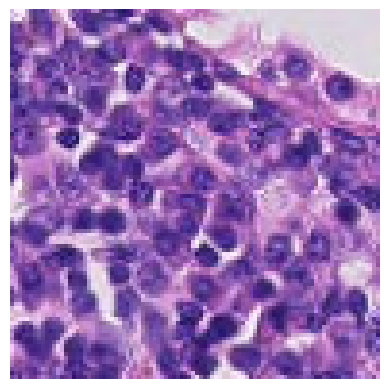

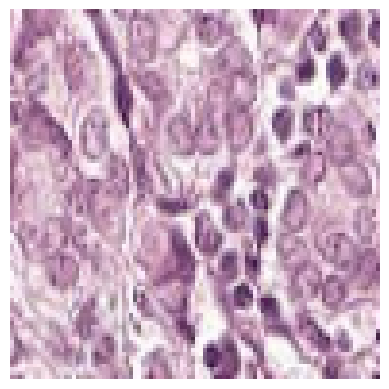

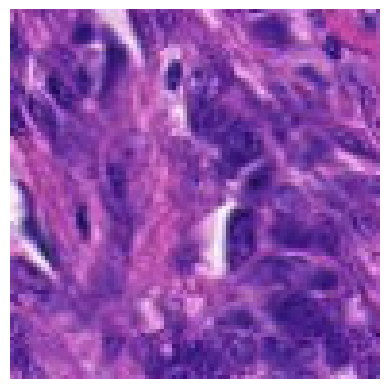

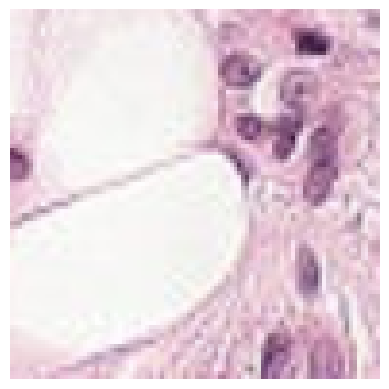

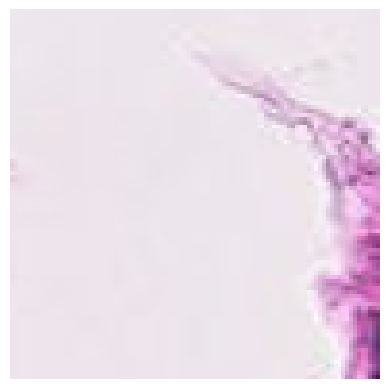

In [10]:
for i in range(5):
    imshow(trn_dataset[i][0])

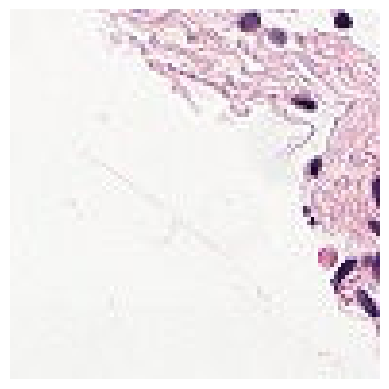

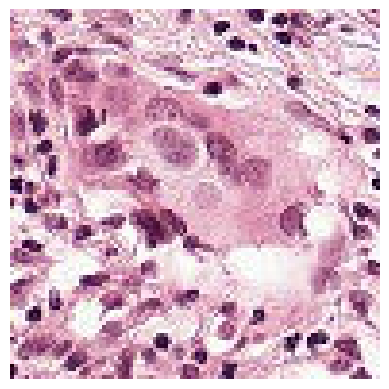

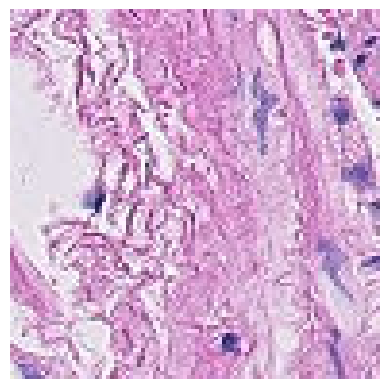

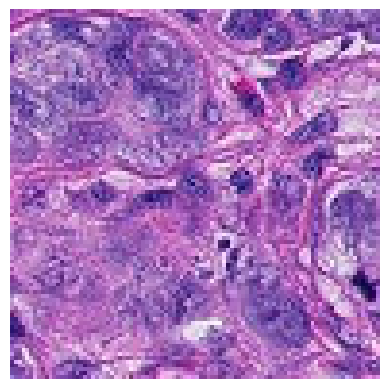

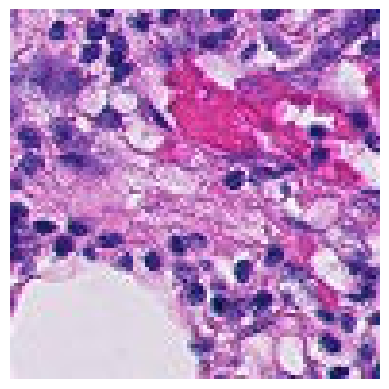

In [11]:
for i in range(5):
    imshow(test_dataset[i][0])

In [12]:
import torch

# data loader
trn_loader = torch.utils.data.DataLoader(trn_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
from tqdm import tqdm


def train(model, criterion, optimizer, trn_loader, test_loader, num_epochs=25):
    for epoch in range(num_epochs):

        model.train()
        trn_loss = 0.0
        trn_corrects = 0
        for inputs, labels in tqdm(trn_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            trn_loss += loss.item() * inputs.size(0)
            trn_corrects += torch.sum(preds == labels.data)

        trn_epoch_loss = trn_loss / len(trn_loader.dataset)
        trn_epoch_acc = trn_corrects.double() / len(trn_loader.dataset)
        print(f"[Train] Loss: {trn_epoch_loss:.4f} Acc: {trn_epoch_acc:.4f}:")

        with torch.no_grad():
            model.eval()
            test_loss = 0.0
            test_corrects = 0
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                test_corrects += torch.sum(preds == labels.data)

            test_epoch_loss = test_loss / len(test_loader.dataset)
            test_epoch_acc = test_corrects.double() / len(test_loader.dataset)
            print(f"[Test] Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.4f}:")

In [15]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [16]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [17]:
model = model.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
train(model, criterion, optimizer, trn_loader, test_loader, num_epochs=10)

100%|██████████| 4096/4096 [02:23<00:00, 28.49it/s]


[Train] Loss: 0.3394 Acc: 0.8554:


100%|██████████| 512/512 [00:17<00:00, 29.81it/s]


[Test] Loss: 0.7665 Acc: 0.7840:


100%|██████████| 4096/4096 [02:18<00:00, 29.52it/s]


[Train] Loss: 0.2807 Acc: 0.8835:


100%|██████████| 512/512 [00:13<00:00, 37.35it/s]


[Test] Loss: 0.4979 Acc: 0.7943:


100%|██████████| 4096/4096 [02:18<00:00, 29.63it/s]


[Train] Loss: 0.2541 Acc: 0.8959:


100%|██████████| 512/512 [00:13<00:00, 38.10it/s]


[Test] Loss: 0.6134 Acc: 0.7965:


100%|██████████| 4096/4096 [02:18<00:00, 29.55it/s]


[Train] Loss: 0.2362 Acc: 0.9038:


100%|██████████| 512/512 [00:14<00:00, 36.49it/s]


[Test] Loss: 0.5830 Acc: 0.8366:


100%|██████████| 4096/4096 [02:20<00:00, 29.09it/s]


[Train] Loss: 0.2262 Acc: 0.9087:


100%|██████████| 512/512 [00:13<00:00, 37.64it/s]


[Test] Loss: 0.5555 Acc: 0.8184:


100%|██████████| 4096/4096 [02:20<00:00, 29.17it/s]


[Train] Loss: 0.2162 Acc: 0.9126:


100%|██████████| 512/512 [00:14<00:00, 36.13it/s]


[Test] Loss: 0.6124 Acc: 0.7965:


100%|██████████| 4096/4096 [02:22<00:00, 28.82it/s]


[Train] Loss: 0.2101 Acc: 0.9155:


100%|██████████| 512/512 [00:14<00:00, 35.98it/s]


[Test] Loss: 0.7030 Acc: 0.7623:


100%|██████████| 4096/4096 [02:20<00:00, 29.18it/s]


[Train] Loss: 0.2029 Acc: 0.9185:


100%|██████████| 512/512 [00:14<00:00, 36.48it/s]


[Test] Loss: 0.6929 Acc: 0.7720:


100%|██████████| 4096/4096 [02:22<00:00, 28.69it/s]


[Train] Loss: 0.1975 Acc: 0.9211:


100%|██████████| 512/512 [00:14<00:00, 36.48it/s]


[Test] Loss: 0.5898 Acc: 0.8108:


100%|██████████| 4096/4096 [02:21<00:00, 28.85it/s]


[Train] Loss: 0.1940 Acc: 0.9225:


100%|██████████| 512/512 [00:13<00:00, 37.06it/s]

[Test] Loss: 0.7315 Acc: 0.7812:


In [20]:
torch.save(model.state_dict(), "./pcam_model/model_pcam.pth")
model.load_state_dict(torch.load("./pcam_model/model_pcam.pth"))

<All keys matched successfully>

In [21]:
import matplotlib.pyplot as plt


def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                imshow(inputs.cpu().data[j])
                print(f"predicted: {preds[j]}")
                print(f"label: {labels[j]}")

                if images_so_far == num_images:
                    return

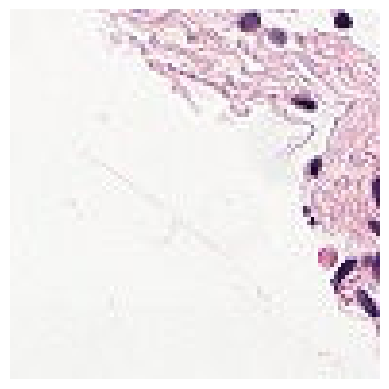

predicted: 0
label: 0


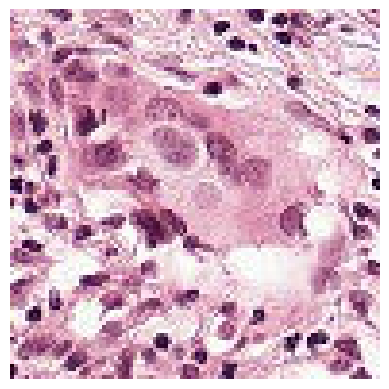

predicted: 1
label: 1


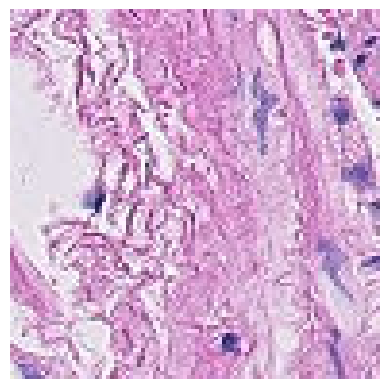

predicted: 0
label: 0


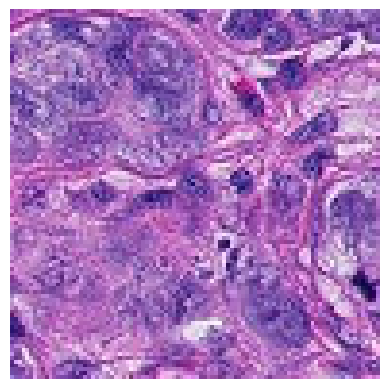

predicted: 1
label: 1


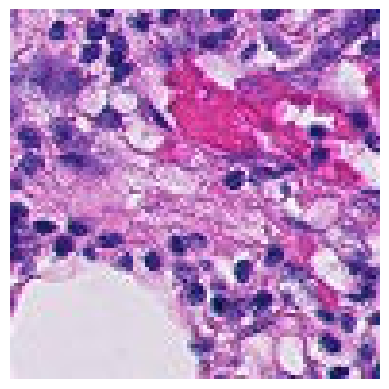

predicted: 0
label: 1


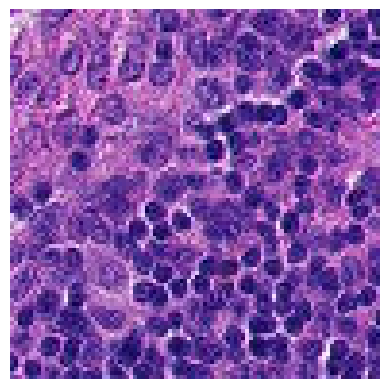

predicted: 0
label: 0


In [22]:
visualize_model(model)